<a href="https://colab.research.google.com/github/abhidendukuri/NeuroFlow-DS-Challenge/blob/master/NeuroFlow_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt


In [ ]:
df = pd.read_csv('phq_all_final.csv', parse_dates=['date', 'patient_date_created'])
df = df.sort_values(['patient_id', 'date'])
df = df.drop(['patient_date_created', 'type'], 1)
df['Ord'] = pd.to_datetime(df['date']).map(dt.datetime.toordinal)

In [ ]:
df

,date,patient_id,score,Ord
21758,2019-12-31 18:35:09.063829,0,1,737424
21759,2020-01-29 19:45:42.206085,0,0,737453
21760,2020-02-26 19:44:31.516123,0,0,737481
21761,2020-03-27 18:25:25.588107,0,0,737511
21762,2020-04-24 18:47:01.412846,0,1,737539
...,...,...,...,...
11876,2019-10-25 12:22:11.743787,18400,1,737357
11877,2019-12-20 13:08:12.641000,18400,1,737413
11878,2020-02-14 14:16:22.136018,18400,2,737469
11879,2020-02-14 14:21:35.770522,18400,4,737469


First thing I want to do is filter out any rows where a patient took the test only once. Since we want to be able to support how well a patient is responding to treatment, monitoring multiple test scores per patient is crucial.

In [ ]:
df = df[df.patient_id.map(df.patient_id.value_counts()) > 1]

(array([23297.,  6698.,  5622.,  3994.,  2441.,  1914.,  1535.,  1203.,
         1099.,  1298.]),
 array([ 0. ,  2.1,  4.2,  6.3,  8.4, 10.5, 12.6, 14.7, 16.8, 18.9, 21. ]),
 <a list of 10 Patch objects>)

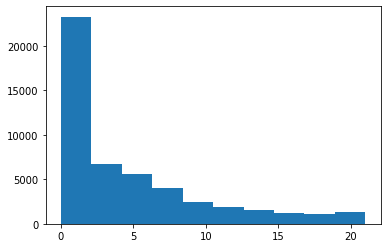

In [ ]:
plt.hist(df.score)

After plotting the first dataframe scores, we can see that there's an incredibly high concentration of values around `score = 0, 1`. To limit that I now want to filter out `patient_ids` that never eclipsed `score >= 10` in any measurement. Since the recommended threshold for clinical evaluation is a score of 10 or higher, I want to make the assumption that patients who have reached this threshold are likely to seek therapy in order to better their condition.


In [ ]:
df['needsEval'] = 1*(df.score >= 10)
df2 = df[df.patient_id.map(df.groupby('patient_id').needsEval.sum() >= 1)]
df2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,date,patient_id,score,Ord,needsEval
31249,2020-04-05 18:08:24.749997,1,10,737520,1
31250,2020-04-11 05:10:14.684719,1,11,737526,1
47485,2020-05-10 18:15:16.919307,2,16,737555,1
47486,2020-06-11 22:57:48.000646,2,11,737587,1
47487,2020-07-09 22:41:48.464082,2,11,737615,1
...,...,...,...,...,...
49699,2020-07-31 17:15:01.746508,18388,11,737637,1
23942,2019-12-18 22:09:13.927837,18392,12,737411,1
23943,2020-01-18 05:08:49.550493,18392,6,737442,0
23944,2020-03-12 17:21:37.950633,18392,11,737496,1


(array([1666., 1270., 1841., 2026., 1971., 1914., 1535., 1203., 1099.,
        1298.]),
 array([ 0. ,  2.1,  4.2,  6.3,  8.4, 10.5, 12.6, 14.7, 16.8, 18.9, 21. ]),
 <a list of 10 Patch objects>)

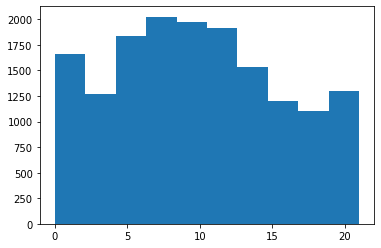

In [ ]:
#plt.figure(figsize=(7,7))
plt.hist(df2.score)


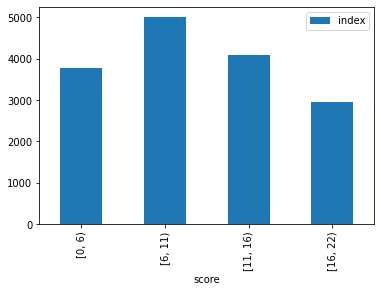

In [ ]:
left = [0, 6, 11, 16]
right = [6, 11, 16, 22]
df_bin = pd.cut(df2.score, pd.IntervalIndex.from_arrays(left, right, closed='left')).reset_index()
df_bin_gp = df_bin.groupby('score').count()
df_bin_gp.plot(kind='bar')


In [ ]:
df_bin_gp

,index
score,
"[0, 6)",3768
"[6, 11)",5006
"[11, 16)",4084
"[16, 22)",2965


After removing those rows, we now have a histogram that is more uniformly distributed and it reveals that most patients report a score between 5-11. Further binning the scores by severity label further supports the statement above. 

Now let's visualize the trends of the 12 patients that took the GAD assessment the highest number of times. This way we can track how well some of these participants respond to, presumably, several rounds of treatment.

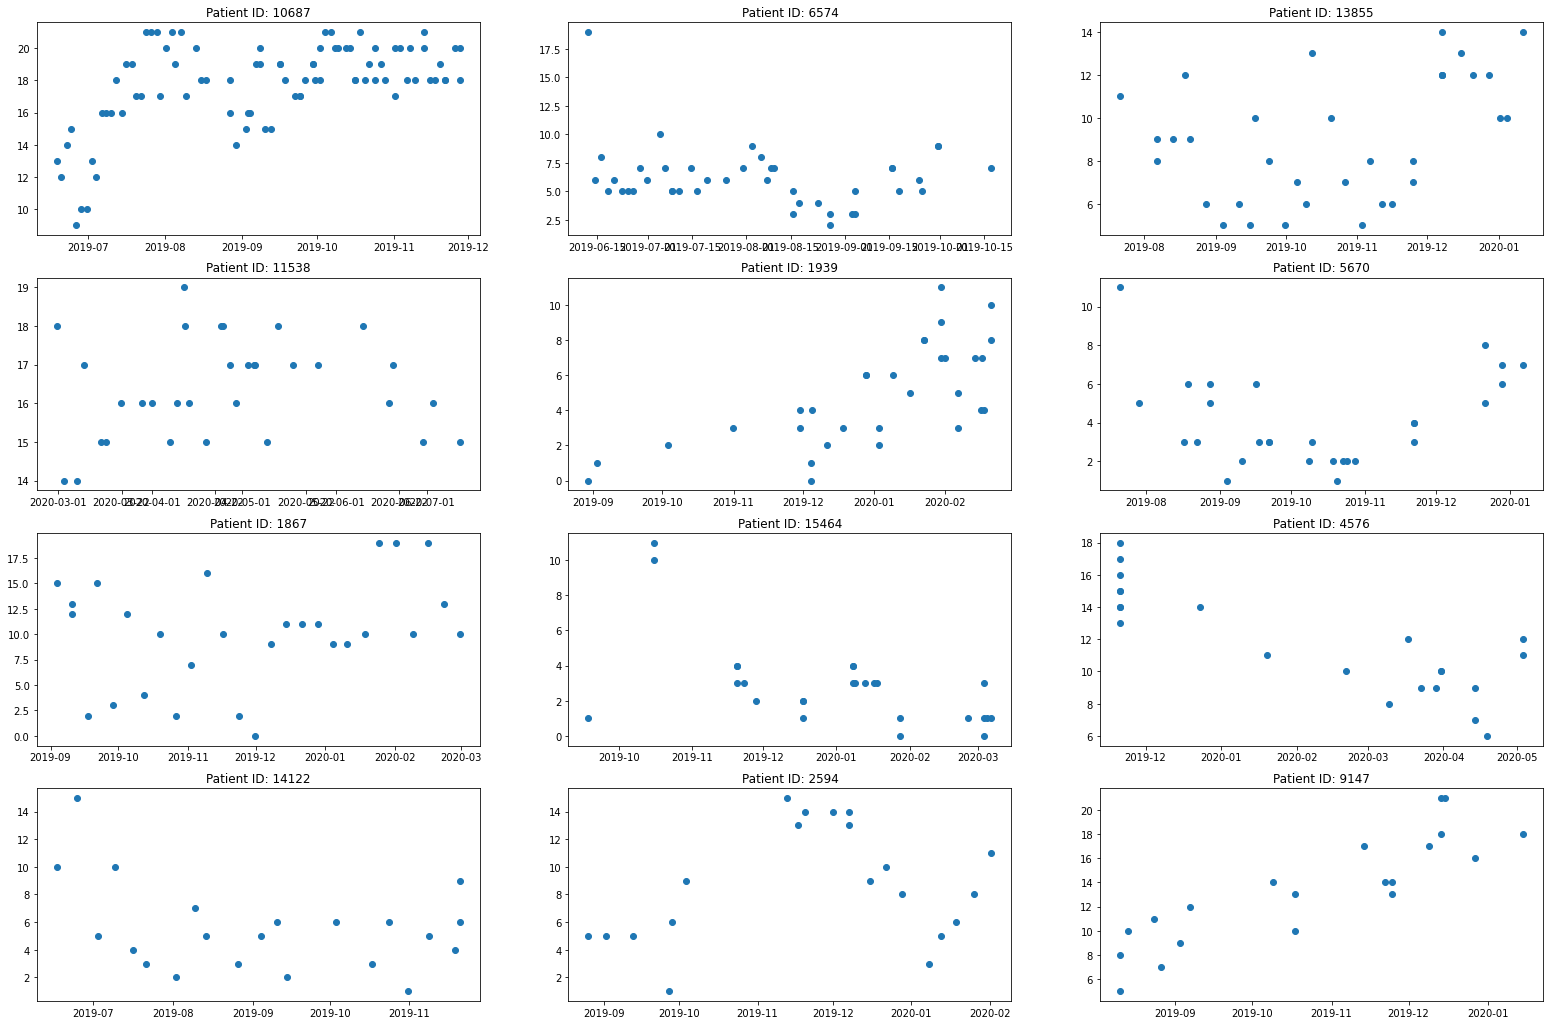

In [ ]:
fig, ax = plt.subplots(4, 3, figsize=(27, 18))
for i, pid in enumerate(df2.patient_id.value_counts().index[:12]):
  ax[i//3, i%3].scatter(df2[df2.patient_id == pid].date, df2[df2.patient_id == pid].score)
  ax[i//3, i%3].set_title('Patient ID: {}'.format(pid))


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lr = LinearRegression()
lr.fit(df[df.patient_id == 10687].Ord.values.reshape(-1, 1), df[df.patient_id == 10687].score)
y_pred = lr.predict(df[df.patient_id == 10687].Ord.values.reshape(-1, 1))
r2_score(df[df.patient_id == 10687].score, y_pred)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

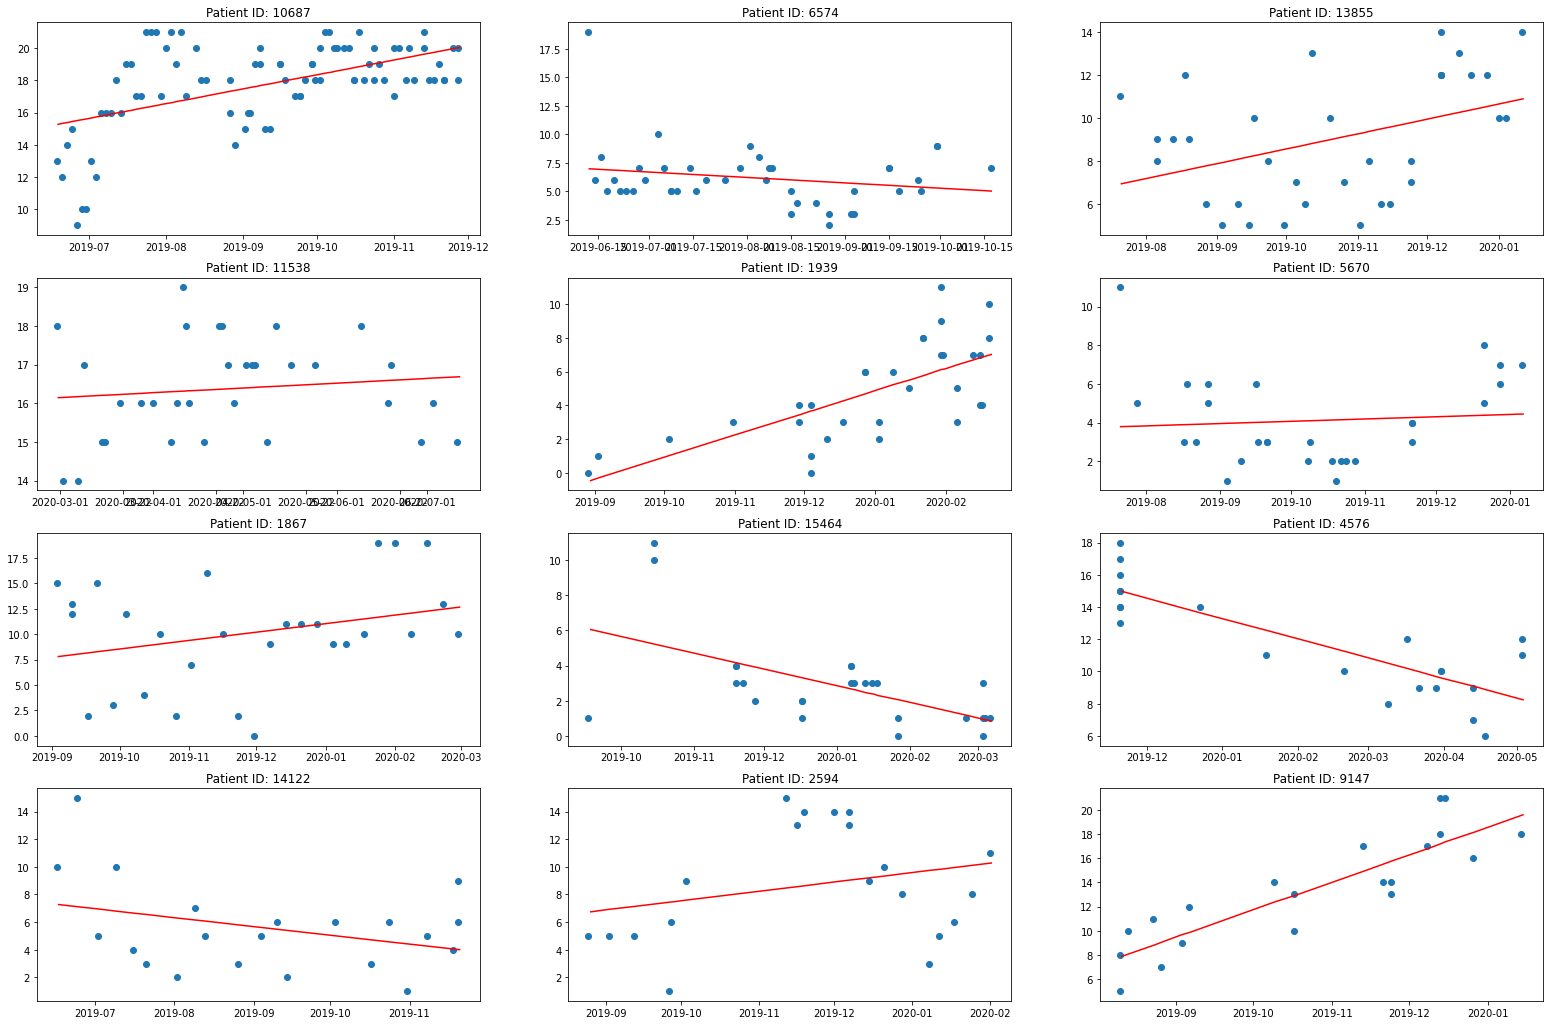

In [ ]:
fig, ax = plt.subplots(4, 3, figsize=(27, 18))
for i, pid in enumerate(df2.patient_id.value_counts().index[:12]):
  ax[i//3, i%3].scatter(df[df.patient_id == pid].Ord, df[df.patient_id == pid].score)
  lr.fit(df[df.patient_id == pid].Ord.values.reshape(-1, 1), df[df.patient_id == pid].score)
  ax[i//3, i%3].set_title('Patient ID: {}'.format(pid))
  ax[i//3, i%3].plot(df[df.patient_id == pid].date, lr.coef_*df[df.patient_id == pid].Ord + lr.intercept_, 'r')


In [ ]:
top15 = df2.patient_id.value_counts().index[:12]

coefs = []
r2 = []
for pid in df2.patient_id.unique():
  lr.fit(df[df.patient_id == pid].Ord.values.reshape(-1, 1), df[df.patient_id == pid].score)
  coefs.append(lr.coef_)
  
  y_pred = lr.predict(df[df.patient_id == pid].Ord.values.reshape(-1, 1))
  r2.append(r2_score(df[df.patient_id == pid].score, y_pred))


In [ ]:
df_lr = pd.DataFrame()
df_lr['patient_id'] = df2.patient_id.unique()
df_lr['coefs'] = np.concatenate(coefs)
df_lr['r2'] = r2
df_lr['resp_to_treatment'] = 1*(df_lr.coefs < 0)
df_resp = df_lr.groupby('resp_to_treatment').count().coefs
df_lr.head(10)

,patient_id,coefs,r2,resp_to_treatment
0,1,0.166667,1.000000,0
1,2,-0.085059,0.782544,1
2,15,0.042361,0.522690,0
3,32,-0.010667,0.014597,1
4,45,0.043478,1.000000,0
5,47,-0.176471,1.000000,1
6,52,0.054935,0.079511,0
7,56,0.099848,0.336191,0
8,57,-0.007641,0.012066,1
9,59,0.117647,1.000000,0


In [ ]:
plt.title('Are GAD Patients Responding to Treatment?')
plt.bar(['No', 'Yes'], df_resp.values)
plt.xlabel('Responding to Treatment')
plt.ylabel('Number of Patients')

Text(0, 0.5, 'Number of Patients')

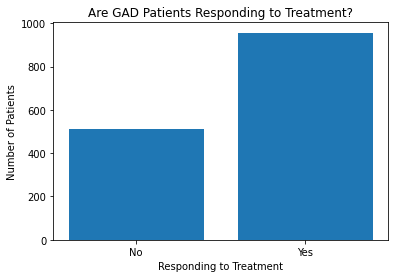

In [ ]:
df_lr_filt = df_lr[(df_lr.r2 != 1) & (df_lr.r2 > 0.25)]

df_resp_filt = df_lr_filt.groupby('resp_to_treatment').count().coefs

plt.title('Are GAD Patients Responding to Treatment?')
plt.bar(['No', 'Yes'], df_resp_filt.values)
plt.xlabel('Responding to Treatment')
plt.ylabel('Number of Patients')